# imports

In [ ]:
from __future__ import print_function
# from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
minor = AutoMinorLocator()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Custom imports

In [ ]:
import sys

sys.path.append('/Users/floorbroekgaarden/Projects/BHNS_project/Scripts')
import coencodeVarious as CV
import ClassCOMPAS     as CC
import ClassFormationChannels as FC
from PostProcessingScripts import * 

from ClassMockMW import * 
from ClassGWcalculations import *
import ClassMockMW

# Read in the data

In [2]:
#general path to file (which I pass to the formationChannel file later)
path = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
#specific path to use now
path1 = path+'COMPASOutput.h5'
fdata = h5.File(path1)
print(fdata['doubleCompactObjects'].keys())

[u'CEalpha', u'CEflag', u'COCoreMassCE2', u'COCoreMassDCOFormation1', u'COCoreMassDCOFormation2', u'COcoreMassCE1', u'ECSNPrimary', u'ECSNSecondary', u'EccentricityPostCEE', u'EccentricityPreCEE', u'HeCoreMassCE1', u'HeCoreMassCE2', u'HeCoreMassDCOFormation1', u'HeCoreMassDCOFormation2', u'ID', u'M1', u'M1ZAMS', u'M2', u'M2ZAMS', u'Metallicity1', u'Metallicity2', u'PISNPrimary', u'PISNSecondary', u'PPISNPrimary', u'PPISNSecondary', u'PrimaryMTCase', u'RL1to2PostCEE', u'RL1to2PreCEE', u'RL2to1PostCEE', u'RL2to1PreCEE', u'RLOFSecondaryAfterCEE', u'SecondaryMTCase', u'SemiMajorAxisPostCEE', u'SemiMajorAxisPreCEE', u'USSNPrimary', u'USSNSecondary', u'bindingEnergyCEEStar1', u'bindingEnergyCEEStar2', u'coreMassCE1', u'coreMassCE2', u'coreMassDCOFormation1', u'coreMassDCOFormation2', u'doubleCommonEnvelopeFlag', u'drawnKick1', u'drawnKick2', u'eccentricityDCOFormation', u'eccentricityInitial', u'eccentricityPrior2ndSN', u'flbv', u'kickDirectionPower', u'lambda1CE', u'lambda2CE', u'mergesInHu

In [ ]:
print(fdata.keys())

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import colors
# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

pcolors = ['#7fcdbb',  '#225ea8', '#081d58', 'black']
dat_save_path = './'
Tobs=4
SNR_lim = 7

In [4]:
#Note above that COMPASOutput.h5 contains all the ascii files
#(if turned on in the pythonSubmit during the simulation)

#easy name for the doubleCompactObjects h5 group
fDCO      = fdata['doubleCompactObjects']

In [5]:
#chosenMetallicity= 0.001



fDCO  = fdata['doubleCompactObjects']
fForm = fdata['formationChannels']
fSN   = fdata['supernovae']
fCE  = fdata['commonEnvelopes']

totalSystems= len((fdata['systems']['mass1'][...].squeeze()))
print(totalSystems, 'total systems simulated')
#Only want BBHs



(30000163, 'total systems simulated')


In [9]:
def obtainDataSTROOPWAFEL(param, pathToDirectory):
    """returns for STROOPWAFEL (AIS) simulation the data of wanted variable
    combines the data from AIS_oratory and AIS_sampling 
    
    param = [xparam, fxparam] ,  are the name of the variable and hdf5 keyname where it is in
    e.g. param = ['M1', 'doubleCompactObjects'] (see also: print(list(f.keys())))
    pathToDirectory is pathname to Directory where AIS_oratory & AIS_sampling directories are
    """ 
    xparam, fxparam = param
    pathAIS = pathToDirectory +'/COMPASOutput.h5'    
    fAIS = h5.File(pathAIS, 'r+')
    
    # get parameter from two directories and combine them
    xvalues = fAIS[fxparam][xparam][...].squeeze()
    return xvalues

def maskTargetDCOsSTROOPWAFEL(DCOtype, boolDCOmask, f, otherSelection, otherparam):
    """returns mask of DCOs of interest
    fxparam  is hdf5 keyname of file where variable for which you want to mask DCOs is in 
    DCOtype = 'BBH' / 'ALL' / 'BHNS' or 'BNS' 
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    pathToDirectory is pathname to Directory where _oratory & _sampling directories are
    """
    
    Hubble, RLOF, Pessimistic = boolDCOmask
    fDCO = f['doubleCompactObjects']
    
    
    # mask binaries of given DCO type
    if DCOtype == 'BNS':
        mask0 = ((fDCO['stellarType1'][...] == 13) & (fDCO['stellarType2'][...] == 13))
    elif (DCOtype == 'BHNS') | (DCOtype == 'NSBH'):
        mask0 = ((fDCO['stellarType1'][...] == 13) & (fDCO['stellarType2'][...] == 14)) | \
            ((fDCO['stellarType1'][...] == 14) & (fDCO['stellarType2'][...] == 13) )          
    elif DCOtype == 'BBH':
        mask0 = ((fDCO['stellarType1'][...] == 14) & (fDCO['stellarType2'][...] == 14))
    elif (DCOtype == 'all') | (DCOtype == 'ALL') :
        mask0 = ((fDCO['stellarType1'][...] == 14) | (fDCO['stellarType1'][...] == 13))
    else:
        print('error: DCO type not known')
        
    # Hubble mask
    if Hubble:
        mask1 = (fDCO['mergesInHubbleTimeFlag'][...]==True) 
    elif not Hubble:
        mask1 = (fDCO['mergesInHubbleTimeFlag'][...]==True) |  (fDCO['mergesInHubbleTimeFlag'][...]==False) 
        
    # RLOF mask
    if RLOF:
        mask2 = (fDCO['RLOFSecondaryAfterCEE'][...]==False)
    elif not RLOF:
        mask2 = (fDCO['RLOFSecondaryAfterCEE'][...]==False) | (fDCO['RLOFSecondaryAfterCEE'][...]==True)
        
    # Pessimistic mask :  if True mask systems that have optimistic CE flag ==1
    if Pessimistic:
        mask3 = np.logical_not(fDCO["optimisticCEFlag"][...] == 1)
    elif not Pessimistic:
        mask3 = np.logical_not(fDCO["optimisticCEFlag"][...] == 1) + \
        np.logical_not(fDCO["optimisticCEFlag"][...] == 0)   
    
    # combine the different masks and the oratory and refinement masks
    combinedmask = mask0 * mask1 * mask2 * mask3
    combinedmask = combinedmask.squeeze()
    if otherSelection =='UFD':
        KpcToKM = 3.086 * 10**(16) # c.kpc to km  
        MyrToYr = 1E6 # yrs
        YrToSec = 3.154 *1E7 #sec        
        UFD_epsilon = otherparam[0]
        UFD_Rvir = otherparam[1]
        Xbh1 = otherparam[2]
        Rns = otherparam[3]

        fSN = f['supernovae']
        seedsOfIntererst = fDCO['seed'][...].squeeze()
        seedsSN = fSN['randomSeed'][...].squeeze()
        bools = np.in1d(seedsSN, seedsOfIntererst)        
        
        tc  = fDCO['tc'][...].squeeze()
        vsys = fSN['systemicVelocity'][...].squeeze()[bools]
        vsysSN2 = vsys[1:][::2]
        traveldistance = tc * vsysSN2 *  MyrToYr * YrToSec
        radiusUFDgalaxy = UFD_epsilon * UFD_Rvir * KpcToKM
        maskCandidatesUFD = (traveldistance <= radiusUFDgalaxy) | ((vsysSN2 <= 44) & (tc * MyrToYr *YrToSec<= radiusUFDgalaxy)) 
        
        combinedmask = maskCandidatesUFD*combinedmask    
    return combinedmask

def obtainweightsSTROOPWAFEL(pathToDirectory):
    """returns weights for all DCOs and all systems for STROOPWAFEL
    pathToDirectory is pathname to Directory where AIS_oratory & AIS_sampling directories are 
    """
    
    pathAIS = pathToDirectory +'/COMPASOutput.h5'
    fAIS = h5.File(pathAIS, 'r+')

    # get the DCO and all system weights
    DCOsweights = fAIS['doubleCompactObjects']['weight'][...].squeeze()
    systemsweights = fAIS['systems']['weight'][...].squeeze()
    return DCOsweights, systemsweights



def plotweightedhistogram(var, varlabel, weights, title):
    """plot histogram of var"""
    
    f, ax = plt.subplots(1, 1,  figsize=(10,10)) 
    
    ax.hist(var, 30, lw = 3, weights=weights, histtype = 'stepfilled')
    ax.set_xlabel(varlabel[0] , fontsize = fs)
    ax.set_ylabel(varlabel[1] , fontsize = fs)
    ax.set_title(title, fontsize = fs)
    ax.grid(True)
    ax.tick_params(labelsize=fs*0.75)
    
    return ax


def plotscatter(x, y, xlab, ylab, z=None, zlab=None):
    f, ax = plt.subplots(1, 1, figsize=(10, 10)) 
    if z is not None and zlab is not None:
        sc = ax.scatter(x, y, s=1, c=z, cmap="viridis")
        cbar = plt.colorbar(sc)
        cbar.set_label(label=zlab, fontsize=fs)
        cbar.ax.tick_params(labelsize=fs*0.8)
    else:
        sc = ax.scatter(x, y, s=1)
    ax.set_xlabel(xlab, fontsize=fs)
    ax.set_ylabel(ylab, fontsize=fs)
    ax.tick_params(labelsize=fs*0.8)
    return ax


def chirp_mass(m1, m2):
    return np.divide(np.power(np.multiply(m1, m2), 3/5), np.power(np.add(m1, m2), 1/5))

path = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
# specific path to use now
path1 = path+'COMPASOutput.h5'
fdata = h5.File(path1, 'r+')



# retrieve variables
M1ZAMS = obtainDataSTROOPWAFEL(param=['M1ZAMS', 'doubleCompactObjects'], pathToDirectory=path)
M2ZAMS = obtainDataSTROOPWAFEL(param=['M2ZAMS', 'doubleCompactObjects'], pathToDirectory=path)
separationInitial = obtainDataSTROOPWAFEL(param=['separationInitial', 'doubleCompactObjects'], pathToDirectory=path)
M1 = obtainDataSTROOPWAFEL(param=['M1', 'doubleCompactObjects'], pathToDirectory=path)
M2 = obtainDataSTROOPWAFEL(param=['M2', 'doubleCompactObjects'], pathToDirectory=path)
a = obtainDataSTROOPWAFEL(param=['separationDCOFormation', 'doubleCompactObjects'], pathToDirectory=path)
e = obtainDataSTROOPWAFEL(param=['eccentricityDCOFormation', 'doubleCompactObjects'], pathToDirectory=path)
tform = obtainDataSTROOPWAFEL(param=['tform', 'doubleCompactObjects'], pathToDirectory=path)
tc = obtainDataSTROOPWAFEL(param=['tc', 'doubleCompactObjects'], pathToDirectory=path)
type1 = obtainDataSTROOPWAFEL(param=['stellarType1', 'doubleCompactObjects'], pathToDirectory=path)
type2 = obtainDataSTROOPWAFEL(param=['stellarType2', 'doubleCompactObjects'], pathToDirectory=path)
Metallicities = obtainDataSTROOPWAFEL(param=['Metallicity1', 'doubleCompactObjects'], pathToDirectory=path) 
# obtain the weights of each binary sampled. This represents the probability of formation. 
weightsDCO, weightsSystems = obtainweightsSTROOPWAFEL(pathToDirectory=path)

# Formation distributions

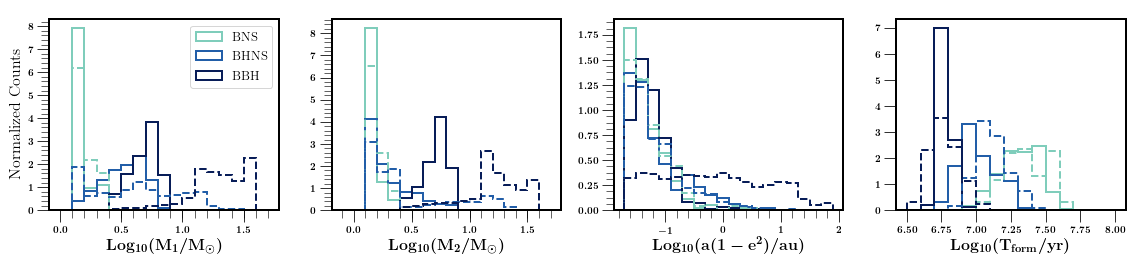

In [18]:
# dat_path = './data/qcflag_1/alpha_1/met_02/'
# dat_path_2 = './data/qcflag_1/alpha_1/met_003/'

model = ['ThinDisk', 'ThickDisk', 'Bulge']
kstars = [[10, 10], [11, 10], [11, 11]]
kstars_1 = [[12, 10, 12], [13, 10, 12], [14, 10, 12]]
kstars_2 =  [[13, 13], [14, 13], [14, 14]]
kstars_plot = ['He + He', 'CO + He', 'CO + CO']
kstars_plot_1 = ['ONe + He, CO, ONe', 'NS + He, CO, ONe', 'BH + He, CO, ONe']
kstars_plot_2 = ['NS + NS', 'BH + NS', 'BH + BH']

kstars_save = ['He_He', 'CO_He', 'CO_CO']
kstars_save_1 = ['ONe_He_ONe', 'NS_He_ONe', 'BH+He_ONe']
kstars_save_2 = ['NS_NS', 'BH_NS', 'BH_BH']
plot_path = 'plots'

fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(3, 4, 1)
ax2 = plt.subplot(3, 4, 2)
ax3 = plt.subplot(3, 4, 3)
ax4 = plt.subplot(3, 4, 4)
# ax5 = plt.subplot(3, 4, 5)
# ax6 = plt.subplot(3, 4, 6)
# ax7 = plt.subplot(3, 4, 7)
# ax8 = plt.subplot(3, 4, 8)
# ax9 = plt.subplot(3, 4, 9)
# ax10 = plt.subplot(3, 4, 10)
# ax11 = plt.subplot(3, 4, 11)
# ax12 = plt.subplot(3, 4, 12)


ii = 0
Types = ['BNS', 'BHNS', 'BBH']


metallicities = [0.022, 0.002]

for indZ, Z in enumerate(metallicities):
    maskZ = (Metallicities == Z)
    for ind_t, DCOtype in enumerate(Types):
        

        
        
        DCOmask = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, boolDCOmask=[0,1,0], f=fdata, otherSelection=None, otherparam=None)

        DCOmask = (DCOmask==1) & (maskZ==1)

        # get characteristics of these systems
        x_M1ZAMS = M1ZAMS[DCOmask]
        x_M2ZAMS = M2ZAMS[DCOmask]
        x_separationInitial = separationInitial[DCOmask]
        x_M1 = M1[DCOmask] #* u.M_sun
        x_M2 = M2[DCOmask] #* u.M_sun
        x_cm = chirp_mass(x_M1,x_M2)
        x_weightsDCO = weightsDCO[DCOmask]
        x_a = a[DCOmask] #* u.au
        x_e = e[DCOmask]
        x_tform = tform[DCOmask] #* 1e6 * u.yr
        x_tc = tc[DCOmask]# * 1e6 #* u.yr
        x_type1 = type1[DCOmask]
        x_type2 = type2[DCOmask]

    #     print(x_M1)
    #     print(np.log10(x_M1))
        if indZ ==0:
            ax1.hist(np.log10(x_M1), bins = np.arange(0, 1.8, 0.1), histtype='step', 
                     lw=2, density=True, color=pcolors[ii], label=DCOtype, weights=x_weightsDCO)
            ax2.hist(np.log10(x_M2), bins = np.arange(-0.1, 1.8, 0.1), histtype='step', 
                     lw=2, density=True, color=pcolors[ii], weights=x_weightsDCO)
            ax3.hist(np.log10(x_a*(1-x_e**2)), bins = np.arange(-1.7, 2, 0.2),  histtype='step', 
                     lw=2,  density=True, color=pcolors[ii], weights=x_weightsDCO)
            ax4.hist(np.log10(x_tform*1e6),  np.arange(6.5, 8.1, 0.1), histtype='step', 
                     lw=2, label=DCOtype, density=True, color=pcolors[ii], weights=x_weightsDCO)
        else:
            ax1.hist(np.log10(x_M1), bins = np.arange(0, 1.8, 0.1), histtype='step', 
                     lw=2, density=True, color=pcolors[ii],  weights=x_weightsDCO, ls='--')
            ax2.hist(np.log10(x_M2), bins = np.arange(-0.1, 1.8, 0.1), histtype='step', 
                     lw=2, density=True, color=pcolors[ii], weights=x_weightsDCO, ls='--')
            ax3.hist(np.log10(x_a*(1-x_e**2)), bins = np.arange(-1.7, 2, 0.2), histtype='step', 
                     lw=2,  density=True, color=pcolors[ii], weights=x_weightsDCO, ls='--')
            ax4.hist(np.log10(x_tform*1e6),  np.arange(6.5, 8.1, 0.1), histtype='step', 
                     lw=2,  density=True, color=pcolors[ii], weights=x_weightsDCO, ls='--')
       
            
            #OTHER METALLICITY
    #     ax1.hist(np.log10(conv_2.primary_plot), bins = np.arange(-0.6, 0.15, 0.05), histtype='step', 
    #               density=True, color=pcolors[ii], ls='--', lw = 2, weights=weightsDCO)
    #     ax2.hist(np.log10(conv_2.secondary_plot), bins = np.arange(-1, 0.15, 0.05), histtype='step', 
    #               density=True, color=pcolors[ii], ls='--', lw = 2, weights=weightsDCO)
    #     ax3.hist(np.log10(conv_2.sep*(1-conv_2.ecc**2)), bins = np.arange(-2.2, 3.1, 0.25), histtype='step', 
    #               density=True, color=pcolors[ii], ls='--', lw = 2, weights=weightsDCO)
    #     ax4.hist(np.log10(conv_2.tphys*1e6), bins = np.arange(7.6, 10.4, 0.2), histtype='step', 
    #               density=True, color=pcolors[ii], ls='--', lw = 2, weights=weightsDCO)
        ii += 1
    ii=0
ax1.legend(loc='upper right', prop={'size' : 13})
ii=0


ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())



ax1.set_ylabel('Normalized Counts', size=16)
# ax5.set_ylabel('Normalized Counts', size=16)
# ax9.set_ylabel('Normalized Counts', size=16)
ax1.set_xlabel(r'$\rm{Log_{10}(M_1/\rm{M_{\odot}})}$', size=16)
ax2.set_xlabel(r'$\rm{Log_{10}(M_2/\rm{M_{\odot}})}$', size=16)
ax3.set_xlabel(r'$\rm{Log_{10}(a(1-e^2)/\rm{au})}$', size=16)
ax4.set_xlabel(r'$\rm{Log_{10}(T_{form}/yr)}$', size=16)



plt.tight_layout()
plt.savefig('plots/fixed_pop.pdf')
plt.show()

In [19]:
from cosmic import MC_samp
import numpy as np
import pandas as pd
import GW_calcs
import MW_maker
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import colors
# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

pcolors = ['#7fcdbb',  '#225ea8', '#081d58', 'black']
dat_save_path = './'
Tobs=4
SNR_lim = 7

ImportError: No module named cosmic

# info about metallicities

In [ ]:
m_sim = fDCO  = fdata['doubleCompactObjects']['M1'][...].squeeze()
print(m_sim)

In [ ]:
#path to the data
pathCOMPASOutput =   '/Volumes/Virgo/DATA/BHNS/Fiducial/'



#But I want only within Hubble time 
Data_01_BHNS            = CC.COMPASData(path=pathCOMPASOutput, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=0.6)
Data_01_BHNS.setCOMPASDCOmask(types='BHNS',  withinHubbleTime=True, optimistic=False)
Data_01_BHNS.setCOMPASData()


#################

#But I want only within Hubble time 
Data_01_BNS            = CC.COMPASData(path=pathCOMPASOutput, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=0.6)
Data_01_BNS.setCOMPASDCOmask(types='BNS',  withinHubbleTime=True, optimistic=False)
Data_01_BNS.setCOMPASData()



###################

#But I want only within Hubble time 
Data_01_BBH            = CC.COMPASData(path=pathCOMPASOutput, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=0.6)
Data_01_BBH.setCOMPASDCOmask(types='BBH',  withinHubbleTime=True, optimistic=False)
Data_01_BBH.setCOMPASData()






In [ ]:
conv = pd.read_hdf('/Volumes/Virgo/DATA/BHNS/Fiducial/COMPASOutput.h5', key='doubleCompactObjects')

# general function for given specific metallicity: 


In [ ]:
d01 = [Data_01_BHNS, Data_01_BBH, Data_01_BNS]

solar = 0.0142  
listDatas = [d01]    
modelnames = ['Fiducial']
linestyles = ['-', '--', '-.', ':']

#We are going to sum and fill between channels 
lowerY = np.zeros(len(listDatas[0][0].metallicityGrid))
log10ZZsun = np.round(np.log10(listDatas[0][0].metallicityGrid/solar),2)
Types      = ['BHNS', 'BHBH', 'NSNS']
Colours    = ['mediumaquamarine','midnightblue','mediumvioletred' ]      


print(metallicities)
for ind_m, modelname in enumerate(modelnames):

    DATA_model = listDatas[ind_m]



    for ind_t, type in enumerate(Types):

        Data = DATA_model[ind_t]
#             if withinHubble == True:
#                 mask = mask & (Data.Hubble == True)
    #         metallicities = Data.metallicitySystems[mask]
        metallicities = Data.metallicitySystems #[mask]
        weights = Data.weight # //floor weights
    #         #Now I have the metallicities of all systems in channel
    #         #Bin them over metallicities and plot fill between
        upperY = np.zeros(len(Data.metallicityGrid))
        upperYNSfirst = np.zeros(len(Data.metallicityGrid))


        for nrZ, Z in enumerate(Data.metallicityGrid):
            maskZ = metallicities == Z
            upperY[nrZ] = np.sum(weights[maskZ]) # //floor weights
            print('N binaries = ', np.sum(Data.weight[nrZ])*1E6)
#             print()
        upperY = np.divide(upperY, Data.totalMassEvolvedPerZ) + lowerY

        print(upperY, r'$\rm dN_{form} / dM_{SFR}  \ \  [10^{-5}\ M_{\odot}^{-1}]\  $')
        print()

#             if ind_t==0:
         



In [ ]:
def mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
                                         dat=Data,
                                         total_sampled_mass=m_sim_tot, metallicity=metallicity):

        maskZ = metallicity
        upperY[nrZ] = np.sum(weights[maskZ]) # //floor weights    


        upperY = np.divide(upperY, Data.totalMassEvolvedPerZ) # rate per SFR 



# MOCK GALAXY 

In [ ]:

def LISA_Galaxy(data, model, m_sim_tot, kstars):
    n_pop = MC_samp.mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
                                         dat=data,
                                         total_sampled_mass=m_sim_tot)
#     print('The number of {0} binaries in the {1} is: {2}'.format(kstars, model, n_pop))
#     if np.all(data.kstar_1 < 14):
#         data = data.loc[data.sep < 100]
#         n_pop = MC_samp.mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
#                                              dat=data,
#                                              total_sampled_mass=m_sim_tot)
#         print('filtered numbers {}'.format(n_pop))

    if n_pop >= 5e5:
        pop_LISA = []
        for ii in range(0,10):
            # do this in chunks for memory
            n_samp = int(n_pop/10)
            if len(pop_LISA) == 0:
                gx_samp = gx_sample(data, model, n_samp)
                gx_samp = gx_samp.loc[gx_samp.f_gw_peak > 1e-5]
                pop_LISA = gx_sample(data, model, n_samp)
            else:
                gx_samp = gx_sample(data, model, n_samp)
                gx_samp = gx_samp.loc[gx_samp.f_gw_peak > 1e-5]
                pop_LISA = pop_LISA.append(gx_samp)
            print(ii)
    else:
        pop_LISA = gx_sample(data, model, n_pop)
        if pop_LISA.ecc.all() == 0.0:
            LISA_fgw = pop_LISA.porb_final
    xGx, yGx, zGx, inc, omega, OMEGA = MC_samp.galactic_positions(gx_component=model, model='McMillan', size=len(pop_LISA))
    pop_LISA['xGx'] = xGx
    pop_LISA['yGx'] = yGx
    pop_LISA['zGx'] = zGx
    pop_LISA['dist'] = ((xGx - 8.0)**2 + (yGx - 0)**2 + (zGx - 0.2)**2)**0.5
    
    return pop_LISA




# retrieve variables
M1 = obtainDataSTROOPWAFEL(param=['M1', 'doubleCompactObjects'], pathToDirectory=path)
M2 = obtainDataSTROOPWAFEL(param=['M2', 'doubleCompactObjects'], pathToDirectory=path)
a = obtainDataSTROOPWAFEL(param=['separationDCOFormation', 'doubleCompactObjects'], pathToDirectory=path)
e = obtainDataSTROOPWAFEL(param=['eccentricityDCOFormation', 'doubleCompactObjects'], pathToDirectory=path)
tform = obtainDataSTROOPWAFEL(param=['tform', 'doubleCompactObjects'], pathToDirectory=path)
tc = obtainDataSTROOPWAFEL(param=['tc', 'doubleCompactObjects'], pathToDirectory=path)
type1 = obtainDataSTROOPWAFEL(param=['stellarType1', 'doubleCompactObjects'], pathToDirectory=path)
type2 = obtainDataSTROOPWAFEL(param=['stellarType2', 'doubleCompactObjects'], pathToDirectory=path)

# obtain the weights of each binary sampled. This represents the probability of formation. 
weightsDCO, weightsSystems = obtainweightsSTROOPWAFEL(pathToDirectory=path)

In [ ]:






# *** SAVE THIS DATA TO A PLACE THAT CAN HANDLE ~15G ***
dat_save_path = '/Volumes/storage/projects/cosmic_paper/gx_real/jeff_re_run/'
for kstar, kstar_plot, kstar_save in zip(kstars, kstars_plot, kstars_save):
    for model in models:
        if model=='ThickDisk':
            dat_path = 'data/re_run/met_003/'
        else:
            dat_path = 'data/re_run/met_02/'

        conv, m_sim, m_sim_tot = MW_maker.read_dat(dat_path=dat_path, 
                                                   kstar_types=kstar)
        
        LISA_Gx = MW_maker.LISA_Galaxy(conv=conv, model=model, 
                              m_sim_tot=m_sim_tot, kstars=kstar_plot)
        
        LISA_Gx.to_hdf(dat_save_path+'gx_dat_'+kstar_save+'_'+model+'.h5', key='galaxy')
        LISA_power = GW_calcs.LISA_power(LISA_Gx, Tobs)   
        LISA_power.to_hdf(dat_save_path+'dat_power_'+kstar_save+'_'+model+'.h5', key='power')
        
        LISA_power = []
        LISA_Gx = []
    print('{} done!'.format(kstar_plot))

In [ ]:
models = ['ThinDisk', 'Bulge', 'ThickDisk']
model_labels = ['Thin Disk', 'Bulge', 'Thick Disk']

Tobs=4
LISA_freq = np.arange(1e-7, 1e-1, 1/(Tobs*yr_sec))
LISA_PSD = GW_calcs.lisa_PSD()
kstars = [[10, 10], [11, 10], [11, 11],
          [12, 10, 12], [13, 10, 12], [14, 10, 12],
          [13, 13], [14, 13], [14, 14]]
kstars_save = ['He_He', 'CO_He', 'CO_CO',
               'ONe_He_ONe', 'NS_He_ONe', 'BH_He_ONe',
               'NS_NS', 'BH_NS', 'BH_BH']
kstars_plot = ['He + He', 'CO + He', 'CO + CO',
               'ONe + He, CO, ONe', 'NS + He, CO, ONe', 'BH + He, CO, ONe',
               'NS + NS', 'BH + NS', 'BH + BH']


# print out pop statistics
for model in models:
    for kstar, kstar_plot, kstar_save in zip(kstars, kstars_plot, kstars_save):
        if model=='ThickDisk':
            dat_path = 'data/re_run/met_003/'
        else:
            dat_path = 'data/re_run/met_02/'

        conv, m_sim, m_sim_tot = MW_maker.read_dat(dat_path=dat_path, 
                                                   kstar_types=kstar)
        print('Model: {}, kstar: {}'.format(model, kstar_plot))
        print('The size of the converged population is: {}'.format(len(conv)))
        print('The total mass required to make the converged population is: {}'.format(m_sim_tot))
        
        Nsim = MC_samp.mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
                                            dat=conv,
                                            total_sampled_mass=m_sim_tot)
        print('The size of the whole population in the Milky Way is: {}'.format(Nsim))
        print('')

# General Plots

In [ ]:
def getvariables(var_x, var_y, model, DCOtype, boolDCOmask, metallicity):
    '''
    var_x = name of x variable we want to get (has to live in DCO file)
    var_y = name of y variable we want to get (has to live in DCO file)
    model = name of directory with data specific model e.g. Fiducial/
    DCOtype = 'BHNS' or ('BBH', 'BNS', 'ALL')
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    '''
    
    path = '/Volumes/TOSHIBA EXT/black_hole-neutron_star/' + model

    #specific path to use now
    path1 = path+'COMPASOutput.h5'
    f = h5.File(path1)
    
    fDCO  = f['doubleCompactObjects']
    fForm = f['formationChannels']
    fSN   = f['supernovae']
    fCE  = f['commonEnvelopes']

    totalSystems= len((f['systems']['mass1'][...].squeeze()))

    
    if metallicity:
        # mask specific requested metallicity  
        maskDCO_temp = maskTargetDCOsSTROOPWAFEL(DCOtype ='BHNS', boolDCOmask=[1,1,0], f=f,\
                                            otherSelection=None, otherparam=None) 
        maskDCO = (fDCO['Metallicity1'][...].squeeze() == metallicity) & (maskDCO_temp == 1)

    else:
        #Only want selected DCO type (combines all metallicities & does not mask specific metallicity)
        maskDCO = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, boolDCOmask=boolDCOmask, f=f,\
                                            otherSelection=None, otherparam=None)


    #what are the seeds of the systems that form BBHs
    seedsOfIntererst = fDCO['seed'][...].squeeze()[maskDCO]
    #Give me a bool of the lines in formation channels that form BBHs
    bools = np.in1d(fForm['m_randomSeed'][...].squeeze(),seedsOfIntererst)
    weightsSystems =  f['systems']['weight'][...].squeeze()
    totalSystems = np.sum(f['systems']['weight'][...].squeeze()) # total weight of DCOs of interest
    totalSystemsDCO = np.sum(fDCO['weight'][...].squeeze()[maskDCO])



    #Because I dont want to retype the columns every time and I dont want 
    #all the data 
    metallicities    = np.log10((fDCO['Metallicity1'][...][maskDCO].squeeze())/0.0142)
    varx             = fDCO[var_x][...][maskDCO].squeeze()
    vary             = fDCO[var_y][...][maskDCO].squeeze()

    return varx, vary



In [ ]:
def BHNSorNSBH(m1bh, m2bh):
    # add later on the 2nd explodes first 
    
    maskBHNS = m1bh >= m2bh # we have a BH=NS

    
    return maskBHNS

def below3Msun(m1bh):
    # add later on the 2nd explodes first 
    
    maskBHNS = m1bh <= 3 # we have a BH=NS

    
    return maskBHNS

In [ ]:
def PlotZAMSmasses(ax, var_x, var_y, BHNSmask, colors, var_xlabel, var_ylabel, datalabel, ind_subchannel ):
    """Plots initial ZAMS masses of BHNS binaries
    var_x, var_y, = array with variable to plot (e.g. M1ZAMS)
    BHNSmask = mask created that =1 for BHNS systems 
    colors =  which color to use for current channel
    var_xlabel, var_ylabel = x,y axis labels of variables 
    datalabel = which label to plot for current channel
    ind_subchannel = index of the current subchannel 
    """
    
    ax.tick_params(labelsize=fs)
    ax.grid();
    
    ax.set_xlabel(var_xlabel, fontsize=fs)
    ax.set_ylabel(var_ylabel, fontsize=fs)

    

    if (ind_subchannel==0) & (datalabel!=None): # only plot label of first subchannel
        print(ind_channel, 'reaching label', datalabel)
        
        ax.scatter(var_x[BHNSmask], var_y[BHNSmask], c=colors, s=30, edgecolor = '', label = datalabel)
        ax.legend(markerscale=2, scatterpoints=1,fontsize=fs-5, loc='upper right', ncol=2, handletextpad=0.1)
    else:
        ax.scatter(var_x[BHNSmask], var_y[BHNSmask], c=colors, s=30, edgecolor = '')
    
#     ax.set_xlim(7, 150)
#     ax.set_ylim(7, 60)
    
    return ax



# COMBINED

In [ ]:
metallicities = [0.001, 0.0142]
metallicityLabels = ['Z=0.001', 'Z=0.0142']

#### Fiducial 
MODEL = 'Fiducial'




fc = FC.FormationChannels(path = pathCOMPASOutput)
fc.formationChannelsSeeds(types='BHNS', withinHubbleTime=True, optimistic=False)
#Based on previous notes I already now the ranks and channels


#But I want only within Hubble time 
Data            = CC.COMPASData(path=pathCOMPASOutput, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=0.6)
Data.setCOMPASDCOmask(types='BHNS',  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
SeedsHubble    = Data.seeds[Data.Hubble==True]


print(len(SeedsHubble))

print(np.sum(Data.weight), len((Data.weight)))



DATAmetallicities = Data.metallicitySystems


stimes_weight = 200



# Calculate STROOPWAFEL GAINS

In [ ]:
print('speed up=',len((Data.weight))/np.sum(Data.weight))

DATAmetallicities = Data.metallicitySystems

for ZZ in set(DATAmetallicities):
#     print('at ', ZZ)
    print()
    maskZZ = DATAmetallicities ==ZZ
    print('at Z=', ZZ, 'the gain =', np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),1), 'x')
    print()
    print('# BHNS = ', len((Data.weight[maskZZ])))
    
    
    
    

    


In [ ]:
f, ax= plt.subplots(ncols=1,figsize=(10,10), 
                  gridspec_kw={"width_ratios":[1.5]})

DATAmetallicities = Data.metallicitySystems

for ZZ in set(DATAmetallicities):
#     print('at ', ZZ)
#     print()
    maskZZ = DATAmetallicities ==ZZ
#     print('at Z=', ZZ, 'the gain =', np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),1), 'x')
    
    Rate = np.sum(Data.weight[maskZZ]) / 1E6
    Gain = np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),2)
    print(Rate)
    ax.scatter(Rate, Gain, s=80, color='g')
    
    if ZZ ==0.001:
       ax.scatter(Rate, 39, s=80, color='r', label="STROOPWAFEL 2019 paper") 
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rate of target population', fontsize=30)
ax.set_ylabel('Gain', fontsize=30)
ax.legend(fontsize=20)
ax.grid(True)
ax.tick_params(labelsize=30)


f.tight_layout()
f.savefig('./BHNS_STROOPWAFEL_gain_LOG.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
array_gains = []


f, ax= plt.subplots(ncols=1,figsize=(10,10), 
                  gridspec_kw={"width_ratios":[1.5]})

DATAmetallicities = Data.metallicitySystems

for ZZ in set(DATAmetallicities):
#     print('at ', ZZ)
#     print()
    maskZZ = DATAmetallicities ==ZZ
#     print('at Z=', ZZ, 'the gain =', np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),1), 'x')
    
    Rate = np.sum(Data.weight[maskZZ]) / 1E6
    Gain = np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),2)
    array_gains.append(Gain)
    
ax.hist(array_gains, 8, color='c')

ax.set_ylabel('nr', fontsize=30)
ax.set_xlabel('Gain', fontsize=30)
ax.legend(fontsize=20)
ax.grid(True)
ax.tick_params(labelsize=30)

print(np.mean(array_gains))
f.tight_layout()
f.savefig('./BHNS_STROOPWAFEL_gain_hist.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
f, ax= plt.subplots(ncols=1,figsize=(10,10), 
                  gridspec_kw={"width_ratios":[1.5]})

DATAmetallicities = Data.metallicitySystems
ax.grid(True)
ax.tick_params(labelsize=30)


for ZZ in set(DATAmetallicities):
#     print('at ', ZZ)
#     print()
    maskZZ = DATAmetallicities ==ZZ
#     print('at Z=', ZZ, 'the gain =', np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),1), 'x')
    
    Rate = np.sum(Data.weight[maskZZ]) / 1E6
    Gain = np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),2)
#     print(Rate)
    ax.scatter(ZZ, Gain, s=80, color='g')
    
#     if ZZ ==0.001:
#        ax.scatter(ZZ, Gain, s=80, color='r') 
ax.set_xlim(min(DATAmetallicities), max(DATAmetallicities))    
# ax.plot([min(DATAmetallicities), max(DATAmetallicities)], [40,40], c='k', linestyle=':', lw=5, label='STROOPWAFEL paper 2019')
ax.scatter([0.001], [39], c='r',  s=80, label='STROOPWAFEL paper 2019')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Metallicity Z', fontsize=30)
ax.set_ylabel('Gain', fontsize=30)



ax.legend(fontsize=20)



f.tight_layout()
f.savefig('./BHNS_STROOPWAFEL_gain_Z.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
# path = '/Volumes/TOSHIBA EXT/black_hole-neutron_star/' + 'Fiducial/'

# #specific path to use now
# path1 = path+'COMPASOutput.h5'
# f_file = h5.File(path1)
# fDCO=f_file['doubleCompactObjects']
# DCOmask = maskTargetDCOsSTROOPWAFEL(DCOtype='BHNS', boolDCOmask=[1,1,1], f=f_file, otherSelection=None, otherparam=None)

In [ ]:
# colorlist = ['', '', '' , '', '', '', '', '']
# colorlist[7] = 'gray'

# for nrC in range(7):
#     if (nrC>=0) & (nrC<=3):
#         cm       = plt.get_cmap('plasma')
#         indd = nrC+1

#         mycolors = [cm(x) for x in np.linspace(0,1 , (5))] 
#         colorlist[nrC] = mycolors[indd] 

# #     if nrC==5:
# #         colorlist[nrC]='lightblue'


#     if (nrC>=4) & (nrC<=6):
#         cm       = plt.get_cmap('viridis_r')
#         indd = nrC-3
#         mycolors = [cm(x) for x in np.linspace(0,1 , (5))] 
#         colorlist[nrC] = mycolors[indd] 

# #     if nrC==6:
# #         colorlist[nrC]='green'
        
        
# dictChannelsBHNSListBolt = [r'\textbf{case A}', r'\textbf{case B}',  r'\textbf{case C}',\
#                             r'\textbf{case B only stable}',\
#                             r'\textbf{case B immediate CE}',
#                             r'\textbf{case C immediate} \textbf{CE}',\
#                              r'\textbf{double-core CE}', r'\textbf{other}']

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotInitialMasses(ax, fc, Data, dictRank, dictList, channelLabelList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    channelLabelList # hack for which labels to give in legend
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            

            
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
#             print DATAmetallicities
            maskZ = (DATAmetallicities==chosenMetallicity)

#             weights = Data.weight[mask] # //floor weights    
            M1ZAMS = Data.m1zams[mask][maskZ]
            M2ZAMS = Data.m2zams[mask][maskZ]
            weights= Data.weight[mask][maskZ]
            
#             print(DATAmetallicities[maskZ])
            
            
            if z_ind==0: # only legendlabel in one of 2 metallicity plots
#                 if nrC in channelLabelList:
#                     print(nrC, Channel, ' channel name')
#                     legendlabel='      '+Channel # white space as placeholder for legend
#                 else: 
                legendlabel=Channel
            else:
                legendlabel=None
            ax[z_ind].scatter(np.log10(M1ZAMS),np.log10(M2ZAMS),s=weights*stimes_weight, linewidth=0.1, \
                              c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])
            #, edgecolor ='k'
#             ax[z_ind].scatter(M1ZAMS,M2ZAMS,s=weights*stimes_weight, edgecolor ='k', linewidth=0.1,\
#                              c=ChannelColours[nrC],label =legendlabel)

#             ax[z_ind].scatter(M1ZAMS, M2ZAMS, c=ChannelColours[nrC],\
#                               s=20, edgecolor = 'k', label =legendlabel,\
#                              linewidth='0.2')
        
            if list(M1ZAMS):
                maxM2ZAMSOLD = max(maxM2ZAMSOLD, np.max(M2ZAMS))
                maxM1ZAMSOLD = max(maxM1ZAMSOLD, np.max(M1ZAMS))
                print( len(M1ZAMS), '= # BHNS')
       
        xx_m1 = np.linspace(5,150,1000)
        ax[z_ind].fill_between(x=np.log10(xx_m1),y1=np.ones_like(xx_m1)*250, y2=np.log10(xx_m1),where= xx_m1<=250,\
                                color='k', alpha =1,hatch='/')
        
        ax[z_ind].plot(np.log10(xx_m1),xx_m1,color ='k', linewidth=1,\
                         linestyle=':')        


        ax[z_ind].plot(xx_m1,np.log10(1./3)*xx_m1,color ='k', linewidth=1,\
                         linestyle=':')         
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
#         ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
#         ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        
#         ax[z_ind].set_xticks([1.,np.log10(15),np.log10(25),np.log10(40),np.log10(60),np.log10(95),np.log10(150)])
#         ax[z_ind].set_xticklabels( [r'$10$',r'$15$',r'$25$',r'$40$',r'$60$', r'$95$',r'$150$'] )#[
#         ax[z_ind].set_yticks([1.,np.log10(12),np.log10(15),np.log10(20),np.log10(25),np.log10(30),np.log10(40)])
#         ax[z_ind].set_yticklabels( [r'$10$',r'$12$',r'$15$',r'$20$',r'$25$', r'$30$',r'$40$'] )#[
        
        
        ax[z_ind].set_xlim(np.log10(10), np.log10(150))
        ax[z_ind].set_ylim(np.log10(9), np.log10(40))  

        
        
        ax2 = ax[z_ind].twiny()
        ax2y = ax[z_ind].twinx()
        
        ax[z_ind].set_ylim(np.log10(9), np.log10(40))
        ax[z_ind].set_xlim(np.log10(10), np.log10(150)) 
        ax[z_ind].tick_params(labelsize=fs)
        ax2.set_xlabel(xlabel2, fontsize=fs)

        ax[z_ind].set_ylim(np.log10(10), np.log10(40)) 
        


        
        
        ax2.set_xticks([np.log10(15),np.log10(50),np.log10(100)])
        ax2.set_xticklabels( [r'$15$',r'$50$', r'$100$'] )#[
        ax2y.set_yticks([np.log10(15),np.log10(25),np.log10(40)])
        ax2y.set_yticklabels( [r'$15$',r'$25$',r'$40$'] )#[        
        
            # OLD: more ticks
#         ax2.set_xticks([1.,np.log10(15),np.log10(25),np.log10(40),np.log10(60),np.log10(95),np.log10(150)])
#         ax2.set_xticklabels( [r'$10$',r'$15$',r'$25$',r'$40$',r'$60$', r'$95$',r'$150$'] )#[
#         ax2y.set_yticks([1.,np.log10(12),np.log10(15),np.log10(20),np.log10(25),np.log10(30),np.log10(40)])
#         ax2y.set_yticklabels( [r'$10$',r'$12$',r'$15$',r'$20$',r'$25$', r'$30$',r'$40$'] )#[
        
        
        ax2.set_xlim(np.log10(10), np.log10(150))
        ax2y.set_ylim(np.log10(9), np.log10(40))  

                
        ax2.tick_params(labelsize=fs)
        ax2y.tick_params(labelsize=fs)
        if z_ind==1:
            ax2y.set_ylabel(ylabel2, fontsize=fs)        
        
        
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95),\
                           xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
              
        
        if z_ind ==0:    
            handles, labels = ax[z_ind].get_legend_handles_labels()
    
    
    return handles, labels



In [ ]:
import pylab as plt

f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})


    
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel2 = r'\textbf{initial mass} $m_{1} \, [\rm{M}_{\odot}]$'
ylabel2 = r'\textbf{initial mass} $m_{2} \, [\rm{M}_{\odot}]$'

xlabel = r'\textbf{initial mass} $\log_{10}(m_{1}) \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{initial mass} $\log_{10}(m_{2}) \, [\rm{M}_{\odot}]$'
# dictChannel_hack = ['\\textbf{Classic \\textbf{channel} (case A $\|$ B $\|$ C)} ', 
#  '\\textbf{Only stable mass transfer}', 
#  '\\textbf{Single-core}, \\textbf{CE} \\textbf{channel}', '\\textbf{Double-core CE} \\textbf{channel}',
#  '\\textbf{other}']


        
# dictChannelsBHNSListBolt = [r'\textbf{Classic  (A)}', r'\textbf{Classic (B)}',  r'\textbf{Classic (C)}',\
#                             r'\textbf{Only stable mass transfer channel}',\
#                             r'\textbf{Immediate single-core CE (B)}',
#                             r'\textbf{Immediate single-core CE (C)}',\
#                              r'\textbf{Immediate double-core CE}', r'\textbf{other}']


# dictChannelsBHNSListBolt = ['\\textbf{Classic \\textbf{channel} (case A $\|$ B $\|$ C)} ', 
#  '\\textbf{Only stable mass transfer}', 
#  '\\textbf{Single-core}, \\textbf{CE} \\textbf{channel}', '\\textbf{Double-core CE} \\textbf{channel}',
#  '\\textbf{other}']

handles, labels = plotInitialMasses(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList,channelLabelList=range(8), withinHubble=True)
# dictChannelsBHNSListBolt = [r'\textbf{case B}', r'\textbf{case B only stable}',\
#                             r'\textbf{case B immediate CE}', r'\textbf{case C}',\
#                             r'\textbf{case C immediate} \textbf{CE}',\
#                             r'\textbf{case A}', r'\textbf{double-core CE}', r'\textbf{other}']
lgd = f.legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
         bbox_to_anchor=(.86, 1.15),  markerscale=3., scatterpoints=1) # loc = 'upper center')


import matplotlib.patches as mpatches 

# ### the code below makes the plot look better
# red_patch = mpatches.Patch(color='gray',  label=r'Traditional')
# default_patch = mpatches.Patch(color='w', label='STROOPWAFEL')
# plt.legend(handles=[red_patch, default_patch], fontsize = 40, loc = 'upper left')
# colors =  ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3'] 





markersize_lgd = 200
lgd.legendHandles[0]._sizes = [markersize_lgd]
lgd.legendHandles[1]._sizes = [markersize_lgd]
lgd.legendHandles[2]._sizes = [markersize_lgd]
lgd.legendHandles[3]._sizes = [markersize_lgd]
lgd.legendHandles[4]._sizes = [markersize_lgd]
# lgd.legendHandles[5]._sizes = [markersize_lgd]
# lgd.legendHandles[6]._sizes = [markersize_lgd]
# lgd.legendHandles[7]._sizes = [markersize_lgd]

f.tight_layout()
f.savefig('./BHNS_ZAMSmasses_channels_combined_pessimistic_4channels.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()        






# OBTAIN SEEDS FOR DETAILED EVOLUTION

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def obtainSeeds(fc, Data, dictRank, dictList, withinHubble=True, Z=0.001):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate([Z]):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            print('at channel',Channel)
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
#                 print(dictRank[Channel], 'dictRank')
                seedsInterest.extend(fc.sortedSeeds[index-1])
            

                #Get metallicity systems this works because seeds in both
                #files are in the same order
                mask = np.in1d(Data.seeds, np.array(seedsInterest))
                if withinHubble == True:
                    mask = mask & (Data.Hubble == True)
                DATAmetallicities = Data.metallicitySystems[mask]
    #             print DATAmetallicities
                maskZ = (DATAmetallicities==chosenMetallicity)

    #             weights = Data.weight[mask] # //floor weights    
                M1ZAMS = Data.m1zams[mask][maskZ]
                M2ZAMS = Data.m2zams[mask][maskZ]
                weights= Data.weight[mask][maskZ]
                
                if Z==0.0142:
                    indZ=26
                    SeedPlus = int(100000000000 * indZ)
                if Z==0.001:
                    indZ=5
                    SeedPlus = int(100000000000 * indZ)

                
                if len(weights):
                    print(index,':', ', ', (np.asarray(seedsInterest)[maskZ][0])-SeedPlus)

    #             print(M1ZAMS[0:5])
    #             print(DATAmetallicities[maskZ])

                if z_ind==0: # only legendlabel in one of 2 metallicity plots
                    legendlabel=Channel
                else:
                    legendlabel=None
                    
                seedsInterest = []



            
            

    
    return 



obtainSeeds(fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True, Z=0.001)


In [ ]:
now at Z = 0.0142
at channel stable A
at channel stable B
1 : ,  423012794
2 : ,  423008360
18 : ,  426005772
28 : ,  428003416
at channel stable C
at channel stable B no CEE
8 : ,  421571114
11 : ,  421529742
31 : ,  427512491
at channel case B immediate CE
6 : ,  429011652
7 : ,  421033982
at channel case C immediate CE
at channel double-core CE
at channel other
22 : ,  424521677
55 : ,  428512938

# Both final masses 

In [ ]:
### ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotfinalmasses(ax, fc, Data, dictRank, dictList, withinHubble=True, BHNSorNSBH=None):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    
    
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        
        rateq3 =0
        rateq5 = 0
        rateALL = 0
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)

        xx = np.linspace(1,25,1000)
        yy0_3 = xx*0.3     
        if z_ind ==0:
            labelqlegend=None
        else:
            labelqlegend=r'$q_{\rm{final}}\leq 3$'
            
        ax[z_ind].fill_between(x=xx,y1=np.ones_like(xx)*2.5, y2=yy0_3,where= yy0_3<=2.5,\
                                color='gray', label=labelqlegend, alpha =0.3,hatch='/')
        ax[z_ind].plot(xx,yy0_3, lw = 2, color='k', linestyle=':' )
#         ax[z_ind].fill_between(x=xx,y1=np.zeros_like(xx), y2=yy0_3,\
#                                 color='gray', label=None, alpha =0.3)
                    
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            maskZ = (DATAmetallicities==chosenMetallicity)

            weightsALL = Data.weight[mask][maskZ].squeeze() # //floor weights    
            M1 = Data.mass1[mask][maskZ]
            M2 = Data.mass2[mask][maskZ]
            
            maskBHNS = getMaskBHNS(m1bh=M1, m2bh=M2)
#             if BHNSorNSBH =='BHNS':
            maskBHNS = maskBHNS
            maskNSBH = ~maskBHNS
#             else:
#                 maskBHNSorNSBH = ~maskBHNS # opposite
            
            weightsBHNS= Data.weight[mask][maskZ][maskBHNS]
            M1BHNS = M1[maskBHNS]
            M2BHNS = M2[maskBHNS]
            weightsNSBH= Data.weight[mask][maskZ][maskNSBH]
            M1NSBH = M1[maskNSBH]
            M2NSBH = M2[maskNSBH]

            
            
            
            maskq3=np.zeros_like(M1)
            maskq5=np.zeros_like(M1)
#             print(np.shape(maskq3), np.shape(maskBHNS),np.shape((M1BHNS/M2NSBH <=3)), 'hello')
            maskq3[maskBHNS] = (M1BHNS/M2BHNS <=3.) 
            maskq3[maskNSBH] = (M2NSBH/M1NSBH <=3.)
            maskq5[maskBHNS] = (M1BHNS/M2BHNS <=5.) 
            maskq5[maskNSBH] = (M2NSBH/M1NSBH <=5.)
            
#             print(maskq3==True)
            
            
            rateq3+=np.sum(weightsALL[maskq3==True])
            rateq5+=np.sum(weightsALL[maskq5==True])
            rateALL+=np.sum(weightsALL)
            
            if z_ind==0: # only legendlabel in one of 2 metallicity plots
                legendlabel=Channel
            else:
                legendlabel=None

            
#             if BHNSorNSBH=='BHNS':
            ax[z_ind].scatter(M1BHNS, M2BHNS,s=weightsBHNS*stimes_weight, edgecolor ='', linewidth=0.1,\
             c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])
#                 ax[z_ind].scatter(M1, M2, c=colorlist[nrC],\
#                                   s=20, edgecolor = 'k', label =legendlabel,\
#                                  linewidth='0.2')
                
#                 massRatio = M2/M1 
                
                
                
#             else:
                
            ax[z_ind].scatter(M2NSBH, M1NSBH,s=
                              weightsNSBH*stimes_weight, edgecolor ='k', linewidth=0.1,\
             c=colorlist[nrC],label=None, zorder=zorderlist[Channel])
#                 ax[z_ind].scatter(M2, M1, c=colorlist[nrC],\
#                                   s=20, edgecolor = 'k', label =None,\
#                                  linewidth='0.2')                

            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props, zorder=100)
#         ax[z_ind].annotate(r'\textbf{%s}'%BHNSorNSBH, xy=(0.6, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)


        
        
        if z_ind ==1:    
            
#             if BHNSorNSBH=='BHNS':
            ax[z_ind].set_xlim(1.8, 12.5)
            ax[z_ind].set_ylim(1.2, 2.5)
            ax[z_ind].legend(fontsize=fs-5, loc='lower right')
        if z_ind ==0:    
            
            handles, labels = ax[z_ind].get_legend_handles_labels()    
            ax[z_ind].set_xlim(1.8, 40)
            ax[z_ind].set_ylim(1.2, 2.5)
            
        print('for Z=',chosenMetallicity, 'we find rates with q <= 3 (5) of ', rateq3/rateALL, '(',rateq5/rateALL,')')
    return handles, labels






In [ ]:
    dictChannelsBHNSListBolt = [r'\textbf{Classic}', \
                                r'\textbf{Only stable mass transfer}',\
                                r'\textbf{Immediate single-core CE }',\
                                 r'\textbf{Immediate double-core CE}', r'\textbf{other}']



f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})


    
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
ylabel = r'\textbf{final mass} $m_{\rm{NS}} \, [\rm{M}_{\odot}]$'
xlabel = r'\textbf{final mass} $m_{\rm{BH}} \, [\rm{M}_{\odot}]$'



handles, labels = plotfinalmasses(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, \
              dictList=dictChannelsBHNSList, withinHubble=True, BHNSorNSBH='BHNS')


# lgd = f.legend(handles, dictChannelsBHNSListBolt,\
#          fontsize=20, ncol=4,\
#          bbox_to_anchor=(.97, 1.1),   scatterpoints=1) # loc = 'upper center')

lgd = f.legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
         bbox_to_anchor=(.9, 1.12),  markerscale=3., scatterpoints=1) # loc = 'upper center')



markersize_lgd = 200
lgd.legendHandles[0]._sizes = [markersize_lgd]
lgd.legendHandles[1]._sizes = [markersize_lgd]
lgd.legendHandles[2]._sizes = [markersize_lgd]
lgd.legendHandles[3]._sizes = [markersize_lgd]
lgd.legendHandles[4]._sizes = [markersize_lgd]
# lgd.legendHandles[5]._sizes = [markersize_lgd]
# lgd.legendHandles[6]._sizes = [markersize_lgd]
# lgd.legendHandles[7]._sizes = [markersize_lgd]

f.tight_layout()
f.savefig('./BHNS_DCOmasses_BOTH_combined_pessimistic_4channels.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()
plt.close()        


       







# ONLY NSBH



In [ ]:
print( np.asarray([1]))

In [ ]:
### ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotBHNSfinal(ax, fc, Data, dictRank, dictList, withinHubble=True, BHNSorNSBH= 'BHNS'):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)

        xx = np.linspace(1,25,1000)
        yy0_3 = xx*0.3     
        if z_ind ==0:
            labelqlegend=None
        else:
            labelqlegend=r'$q_{\rm{final}}\geq 3$'
            
        ax[z_ind].fill_between(x=xx,y1=np.ones_like(xx)*2.5, y2=yy0_3,where= yy0_3<=2.5,\
                                color='gray', label=labelqlegend, alpha =0.3,hatch='/')
        ax[z_ind].plot(xx,yy0_3, lw = 2, color='k', linestyle=':' )
#         ax[z_ind].fill_between(x=xx,y1=np.zeros_like(xx), y2=yy0_3,\
#                                 color='gray', label=None, alpha =0.3)
                    
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            maskZ = (DATAmetallicities==chosenMetallicity)

#             weights = Data.weight[mask] # //floor weights    
            M1 = Data.mass1[mask][maskZ]
            M2 = Data.mass2[mask][maskZ]
            
            maskBHNS = getMaskBHNS(m1bh=M1, m2bh=M2)
            if BHNSorNSBH =='BHNS':
                maskBHNSorNSBH = maskBHNS
            else:
                maskBHNSorNSBH = ~maskBHNS # opposite
            
            weights= Data.weight[mask][maskZ][maskBHNSorNSBH]
            M1 = M1[maskBHNSorNSBH]
            M2 = M2[maskBHNSorNSBH]


        
            if z_ind==0: # only legendlabel in one of 2 metallicity plots
                legendlabel=Channel
            else:
                legendlabel=None

            
            if BHNSorNSBH=='BHNS':
                ax[z_ind].scatter(M1, M2,s=weights*stimes_weight, edgecolor ='k', linewidth=0.1,\
                 c=colorlist[nrC],label =legendlabel)
#                 ax[z_ind].scatter(M1, M2, c=colorlist[nrC],\
#                                   s=20, edgecolor = 'k', label =legendlabel,\
#                                  linewidth='0.2')
                
                massRatio = M2/M1 
                
                
                
            else:
                
                ax[z_ind].scatter(M2, M1,s=weights*stimes_weight, edgecolor ='', linewidth=0.1,\
                 c=colorlist[nrC],label=None)
#                 ax[z_ind].scatter(M2, M1, c=colorlist[nrC],\
#                                   s=20, edgecolor = 'k', label =None,\
#                                  linewidth='0.2')                

            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
        ax[z_ind].annotate(r'\textbf{%s}'%BHNSorNSBH, xy=(0.6, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)


        
        

        
        
        
        if z_ind ==1:    
            ax[z_ind].legend(fontsize=fs-5, loc='lower right')
            if BHNSorNSBH=='BHNS':
                ax[z_ind].set_xlim(2.5, 15)
                ax[z_ind].set_ylim(1.2, 2.5)
            else:
                ax[z_ind].set_xlim(2.5, 15)
                ax[z_ind].set_ylim(1.2, 2.5)            

        if z_ind ==0:    
            handles, labels = ax[z_ind].get_legend_handles_labels()    
            if BHNSorNSBH=='BHNS':
                ax[z_ind].set_xlim(2.5, 41)
                ax[z_ind].set_ylim(1.2, 2.5)
            else:
                ax[z_ind].set_xlim(2.5, 15)
                ax[z_ind].set_ylim(1.2, 2.5)              
            
    return handles, labels





In [ ]:


# dictChannelsBHNStemp = { 'stable A':[10,16,19], 'case B immediate CE':[6,7,20,29],\
#                     'stable B':[25], 'stable B no CEE':[8,11,31,], \
#                     'stable C':[4,15,26],\
#                 r'case C immediate CE':[17,21],  r'double-core CE':[3,12,13,23,24,27,30],  \
#                     'other':[22, 32,33,34,35,36,37,38,39,40,41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]\
#                     }

# # # dictChannelsBHNStemp = 'stable B':[1,2,5,9,14,18,25,28]
# dictChannelsBHNSListtemp = ['stable B'] 

f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})


    
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
ylabel = r'\textbf{final mass} $m_{\rm{NS}} \, [\rm{M}_{\odot}]$'
xlabel = r'\textbf{final mass} $m_{\rm{BH}} \, [\rm{M}_{\odot}]$'



handles, labels = plotBHNSfinal(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, \
              dictList=dictChannelsBHNSList, withinHubble=True, BHNSorNSBH='BHNS')


lgd = f.legend(handles, dictChannelsBHNSListBolt,\
         fontsize=20, ncol=4,\
         bbox_to_anchor=(.97, 1.1),   scatterpoints=1) # loc = 'upper center')

# lgd.legendHandles.legmarker.set_markersize(200)
# lgd.legendHandles[1]._legmarker.set_markersize(6)

markersize_lgd = 120
lgd.legendHandles[0]._sizes = [markersize_lgd]
lgd.legendHandles[1]._sizes = [markersize_lgd]
lgd.legendHandles[2]._sizes = [markersize_lgd]
lgd.legendHandles[3]._sizes = [markersize_lgd]
lgd.legendHandles[4]._sizes = [markersize_lgd]
lgd.legendHandles[5]._sizes = [markersize_lgd]
lgd.legendHandles[6]._sizes = [markersize_lgd]
lgd.legendHandles[7]._sizes = [markersize_lgd]

f.tight_layout()
f.savefig('./BHNS_DCOmasses_NSBH_combined_pessimistic.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()
plt.close()        


       






In [ ]:
f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})


    
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
ylabel = r'\textbf{final mass} $m_{\rm{NS}} \, [M_{\odot}]$'
xlabel = r'\textbf{final mass} $m_{\rm{BH}} \, [M_{\odot}]$'



_, _ = plotBHNSfinal(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, \
              dictList=dictChannelsBHNSList, withinHubble=True, BHNSorNSBH='NSBH')




plt.tight_layout()
plt.savefig('./NSBH_DCOmasses_NSBH_combined_pessimistic.png')
plt.show()
plt.close()        







# separation and ZAMS mass

# plot q and Separation

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotInitialqVSseparation(ax, fc, Data, dictRank, dictList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
#             print DATAmetallicities
            maskZ = (DATAmetallicities==chosenMetallicity)

#             weights = Data.weight[mask] # //floor weights    
            M1ZAMS = Data.m1zams[mask][maskZ]
            M2ZAMS = Data.m2zams[mask][maskZ]
            separationInitial = Data.separationzams[mask][maskZ]
            separationInitial = np.log10(separationInitial)
            qZAMS = M2ZAMS /M1ZAMS
            weights= Data.weight[mask][maskZ]
#             print(DATAmetallicities[maskZ])

        
#             print(DATAmetallicities[maskZ])

            if z_ind==0: # only legendlabel in one of 2 metallicity plots
                legendlabel=None
            else:
                legendlabel=None
            

            if len(weights):

                ax[z_ind].scatter(qZAMS,separationInitial,s=weights*stimes_weight, edgecolor ='', linewidth=0.1,\
                                 c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])
                                  

            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
#         ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)


#         ax[z_ind].grid(True)
        ax[z_ind].set_xlim(0, 1)
        ax[z_ind].set_ylim(-1.1, 2) 

        
#         ax[z_ind].set_xticks([-1,np.log10(0.3),np.log10(1),np.log10(3),np.log10(10),np.log10(30),np.log10(100)])
#         ax[z_ind].set_xticklabels( [r'$0.1$',r'$0.3$',r'$1.0$',r'$3.0$',r'$10$', r'$30$',r'$100$'] )#[
#         ax[z_ind].set_yticks([-1,np.log10(0.3),np.log10(1),np.log10(3),np.log10(10),np.log10(30),np.log10(100)])
#         ax[z_ind].set_yticklabels( [r'$0.1$',r'$0.3$',r'$1.0$',r'$3.0$',r'$10$', r'$30$',r'$100$'] )#[        

        ax2y = ax[z_ind].twinx()
        
        ax2y.set_xlim(0,1)
        ax2y.set_ylim(-1.1, 2) 
#         ax2y.set_yscale('log')
        ax2y.tick_params(labelsize=fs)
        if z_ind==1:
            ax2y.set_ylabel(ylabel2, fontsize=fs)           
                
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())

        ax2y.set_yticks([np.log10(0.5),np.log10(5),np.log10(50)])
        ax2y.set_yticklabels( [r'$0.5$',r'$5$', r'$50$'] )#[        


        
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.55, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
#         if z_ind ==0:  
#             handles, labels = ax[z_ind].get_legend_handles_labels()
            
            
    
    return handles, labels



In [ ]:

# dictChannelsBHNStemp = { 'stable A':[10,16,19], 'case B immediate CE':[6,7,20,29],\
#                     'stable B':[25], 'stable B no CEE':[8,11,31,], \
#                     'stable C':[4,15,26],\
#                 r'case C immediate CE':[17,21],  r'double-core CE':[3,12,13,23,24,27,30],  \
#                     'other':[22, 32,33,34,35,36,37,38,39,40,41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]\
#                     }

# # # dictChannelsBHNStemp = 'stable B':[1,2,5,9,14,18,25,28]
# dictChannelsBHNSListtemp = ['stable B'] 



xlabel = r'\textbf{initial mass ratio} $q_{\rm{ZAMS}} $'
ylabel2 = r'\textbf{initial separation} $a \, [\rm{AU}]$'
ylabel = r'\textbf{initial separation} $\log_{10}(a) \, [\rm{AU}]$'


f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})




andles, labels = plotInitialqVSseparation(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)


# f.legend(handles, labels, fontsize=20, ncol=4,bbox_to_anchor=(.95, 1.1)) # loc = 'upper center')
plt.tight_layout()
plt.savefig('./BHNS_ZAMSqseparation_combined_pessimistic_4channels.png')
plt.show()
plt.close()        






# Peters merger time calculation

In [ ]:
def timeToCoalescenceUsingInterpolation( a0,  e0,  m1,  m2):
    """/*
     Calculate the time to coalescence for a binary with arbitrary eccentricity using interpolation
     
     This is Equation 5.14 in Peters 1964 http:#journals.aps.org/pr/pdf/10.1103/PhysRev.136.B1224

     Parameters
     -----------
     a0 : 
        Initial semi-major axis in SI units
     e0 : 
        Initial eccentricity
     m1 :  
        Primary mass in SI units
     m2 : 
        Secondary mass in SI units
     
     Returns
     --------
     t_coalesce : 
        Time to coalescence in SI units (s)

     */
    """
    # Declare some variables
    tc       = 0.0;                                          # Time for a circular binary to coalesce
    beta     = 0.0;                                          # Beta constant (function of masses)
    tovertc  = 0.0;                                          # Result of interpolation of t/tc function
    

    # Calculate circular time to coalescence
    beta = calculateBeta(m1, m2);                                   # Masses should be in SI
    tc = a0*a0*a0*a0/(4.0*beta);                                    # Calculate time for a circular binary to merge
    
    # calculate t/tc using the interpolated function
    #tovertc = polynomialFitToToverTc(e0);                           # Ratio of inspiral time to that of circular system
    if((e0==0.0)or(e0==0)):
		return	tc;

    c0=a0*(1.0-e0*e0)*np.power(e0,-12.0/19.0)*np.power(1.0+(121.0*e0*e0/304.0), -870.0/2299.0);
		
		
    if(e0<0.01): 
		return c0*c0*c0*c0*np.power(e0,48.0/19.0)/(4.0*beta);
    

    if(e0>0.99):
		# Approximation of eq. 5.14 of Peters 1964, for high eccentricities
		return (768.0/425.0)*tc*np.power((1.0-(e0*e0)),3.5);
    	
    # otherwise: numerically integrate
    summ=0;
    de=e0/10000;
    e=0
    while(e<e0):
        summ=summ+de*np.power(e,29.0/19.0)*np.power((1.0+(121.0/304.0)*e*e),1181.0/2299.0)/np.power((1-e*e),1.5);
        e=e+de

    return 12.0/19.0*c0*c0*c0*c0/beta*summ;



def calculateBeta( m1,  m2):
    """/*
     # Calculate the constant beta based on masses as defined in Equation 5.9 in Peters 1964 http:#journals.aps.org/pr/pdf/10.1103/PhysRev.136.B1224
     
     Parameters
     -----------
     m1 : float
        Primary mass in SI units
     m2 : float
        Secondary mass in SI units
     
     Returns
     --------
     beta : float
        Mass parameter beta
 
     */
     """
    M = m1 + m2;

    return (64.0/5.0)*G*G*G*m1*m2*M*np.power(c,-5.0);



In [ ]:
from astropy import units as u
from astropy import constants as const
a =1.*u.R_sun
M1 = 10*u.M_sun
M2 = 1.4*u.M_sun

c= const.c.si
G = const.G.si

print(timeToCoalescenceUsingInterpolation(a0=a.to(u.meter), e0=0.98, m1=M1.to(u.kg),  m2=M2.to(u.kg)).to(u.year))

In [ ]:
Niter = 50

solvetime_a_10Myr = np.logspace(-1, 3, Niter)*u.R_sun
solvetime_e_10Myr = []
M1 = 10*u.M_sun
M2 = 1.4*u.M_sun


# 1 Gyr
Twanted = 10*1E6 * u.year

for ind_a, solve_a in enumerate(solvetime_a_10Myr):
    print('at ind, ',ind_a)
    for ind_e, ecc in enumerate(np.linspace(0,1,Niter)):
        solve_a = solve_a
        mergertime = timeToCoalescenceUsingInterpolation(a0=solve_a.to(u.meter), e0=ecc, m1=M1.to(u.kg),  m2=M2.to(u.kg)).to(u.year)
        if (mergertime <= Twanted) | (ecc==1):
            solvetime_e_10Myr.append(ecc)
            break 
        
solvetime_a_1Myr = np.logspace(-1, 3, Niter)*u.R_sun
solvetime_e_1Myr = []
M1 = 10*u.M_sun
M2 = 1.4*u.M_sun
# 1 Gyr
Twanted = 1*1E6 * u.year

for ind_a, solve_a in enumerate(solvetime_a_10Myr):
    print('at ind, ',ind_a)
    for ind_e, ecc in enumerate(np.linspace(0,1,Niter)):
        solve_a = solve_a
        mergertime = timeToCoalescenceUsingInterpolation(a0=solve_a.to(u.meter), e0=ecc, m1=M1.to(u.kg),  m2=M2.to(u.kg)).to(u.year)
        if (mergertime <= Twanted) | (ecc==1):
            solvetime_e_1Myr.append(ecc)
            break             
            
H0                         = 67.8;         #                          // Hubble's Constant in km s^-1 Mpc^-1  (from plank approx 67.80±0.77) CPLB: Use WMAP value
H0SI                       = (H0*1000/3E22) *u.meter / (u.second*u.meter) ; 
Htime = 1/H0SI 
HubbleTime = Htime.to(u.year)            
            
solvetime_a_Htime = np.logspace(-1, 3, Niter)*u.R_sun
solvetime_e_Htime = []
M1 = 10*u.M_sun
M2 = 1.4*u.M_sun
# 1 Gyr
Twanted = HubbleTime

for ind_a, solve_a in enumerate(solvetime_a_10Myr):
    print('at ind, ',ind_a)
    for ind_e, ecc in enumerate(np.linspace(0,1,Niter)):
        solve_a = solve_a
        mergertime = timeToCoalescenceUsingInterpolation(a0=solve_a.to(u.meter), e0=ecc, m1=M1.to(u.kg),  m2=M2.to(u.kg)).to(u.year)
        if (mergertime <= Twanted) | (ecc==1):
            solvetime_e_Htime.append(ecc)
            break           
        

In [ ]:
#  1*1E4 * u.year
# 10 000 year 
solvetime_a_1000year = np.logspace(-1, 1, Niter)*u.R_sun
solvetime_e_1000year = []
M1 = 10*u.M_sun
M2 = 1.4*u.M_sun
# 1 Gyr
Twanted = 1*1E4 * u.year

for ind_a, solve_a in enumerate(solvetime_a_10Myr):
    print('at ind, ',ind_a)
    for ind_e, ecc in enumerate(np.linspace(0,1,Niter)):
        solve_a = solve_a
        mergertime = timeToCoalescenceUsingInterpolation(a0=solve_a.to(u.meter), e0=ecc, m1=M1.to(u.kg),  m2=M2.to(u.kg)).to(u.year)
        if (mergertime <= Twanted) | (ecc==1):
            solvetime_e_1000year.append(ecc)
            break           
        

In [ ]:
print(solvetime_e)

# eccenttricity & Separation 

In [ ]:



''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    
AUtoRsun = 214.939

def ploteVSseparation(ax, fc, Data, dictRank, dictList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at Z = %s'%chosenMetallicity) 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            
            maskZ = (DATAmetallicities==chosenMetallicity)

            eccentricityDCOFormation=Data.eccentricityDCOFormation[mask][maskZ]
            separationDCOFormation=Data.separationDCOFormation[mask][maskZ]           
            
            M1ZAMS = Data.m1zams[mask][maskZ]
            M2ZAMS = Data.m2zams[mask][maskZ]
            M1 = Data.mass1[mask][maskZ]
            M2 = Data.mass2[mask][maskZ]            
#             separationInitial = Data.separationzams[mask][maskZ]
#             separationInitial = np.log10(separationInitial)
            qZAMS = M2ZAMS /M1ZAMS
            weights= Data.weight[mask][maskZ]
            
            maskk = M1>=0

            if z_ind==0: # only legendlabel in one of 2 metallicity plots
                legendlabel=None
            else:
                legendlabel=None
            

            if len(weights):

                ax[z_ind].scatter(np.log10(separationDCOFormation[maskk]*AUtoRsun),eccentricityDCOFormation[maskk],\
                                  s=weights*stimes_weight, edgecolor ='', linewidth=0.1,\
                                 c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])
            
            
        # PLOT MERGER TIME SOLVER 
#         solvetime_loga = (np.log10(solvetime_a_1000year/u.R_sun))
#         ax[z_ind].plot(solvetime_loga, solvetime_e_1000year, lw=3, color = 'k',linestyle=':', zorder=2000)        
        
#         #10 Myr
#         solvetime_loga = (np.log10(solvetime_a_10Myr/u.R_sun))
#         ax[z_ind].plot(solvetime_loga, solvetime_e_10Myr, lw=3, color = 'k',linestyle=':',  zorder=2000)

        
#         solvetime_loga = (np.log10(solvetime_a_Htime/u.R_sun))
#         ax[z_ind].plot(solvetime_loga, solvetime_e_Htime, lw=3, linestyle=':', color = 'k', zorder=2000)        
        
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)

        ax[z_ind].set_xlim(-1, 3)
        ax[z_ind].set_ylim(0, 1) 
        
#         ax[z_ind].text()
#         ax[z_ind].set_xticks([-1,np.log10(0.3),np.log10(1),np.log10(3),np.log10(10),np.log10(30),np.log10(100)])
#         ax[z_ind].set_xticklabels( [r'$0.1$',r'$0.3$',r'$1.0$',r'$3.0$',r'$10$', r'$30$',r'$100$'] )#[
#         ax[z_ind].set_xticks([-1,np.log10(0.3),np.log10(1),np.log10(3),np.log10(10),np.log10(30),np.log10(1000)])
#         ax[z_ind].set_xticklabels( [r'$0.1$',r'$0.3$',r'$1.0$',r'$3.0$',r'$10$', r'$30$',r'$10^3$'] )#[        

#         ax2y = ax[z_ind].twiny()
        
#         ax2y.set_xlim(-1,3)


#         ax2y.tick_params(labelsize=fs)
        ax[z_ind].set_xlabel(xlabel2, fontsize=fs)           
                
#         ax2y.yaxis.set_minor_locator(AutoMinorLocator())        
        
#         ax2y.set_xticks([np.log10(0.5),np.log10(1),np.log10(3),np.log10(10),np.log10(30),np.log10(1000)])
#         ax2y.set_xticklabels( [,r'$0.5$',r'$1.0$',r'$3.0$',r'$10$', r'$30$',r'$10^3$'] )#[        

        
        
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.6, 0.10), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)

    
    return handles, labels







In [ ]:


# # case BB channel B : 2,14,18,25,28
# # case BB channel C: 4,
xlabel = r' \textbf{post SN2 separation} $(a) \, [\rm{R}_{\odot}]$' #\rm{R}_{\odot}
ylabel = r'\textbf{post SN2 eccentricity} '
xlabel2 = r' \textbf{post SN2 separation} $\log_{10}(a) \, [\rm{R}_{\odot}]$'

f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})




_,_ = ploteVSseparation(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)


# f.legend(handles, labels, fontsize=20, ncol=4,bbox_to_anchor=(.95, 1.1)) # loc = 'upper center')
plt.tight_layout()
plt.savefig('./BHNS_DCOseparationeccentricity_combined_pessimistic_4channels.png')
plt.show()
plt.close()        







In [ ]:
H0                         = 67.8;         #                          // Hubble's Constant in km s^-1 Mpc^-1  (from plank approx 67.80±0.77) CPLB: Use WMAP value
H0SI                       = (H0*1000/3E22) *u.meter / (u.second*u.meter) ; 
Htime = 1/H0SI 
HubbleTime = Htime.to(u.year)

In [ ]:
print(Htime.to(u.year))

In [ ]:
print(np.log10(solvetime_a/u.R_sun))

# eccenttricity & Separation 

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


# def plotDCOseparationeccentricity(ax, fc, Data, dictRank, dictList, withinHubble=True):
# ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotInitialqVSseparation(ax, fc, Data, dictRank, dictList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
#             print DATAmetallicities
            maskZ = (DATAmetallicities==chosenMetallicity)

#             weights = Data.weight[mask] # //floor weights    
            M1ZAMS = Data.m1zams[mask][maskZ]
            M2ZAMS = Data.m2zams[mask][maskZ]
            separationInitial = Data.separationzams[mask][maskZ]
            separationInitial = np.log10(separationInitial)
            qZAMS = M2ZAMS /M1ZAMS
            weights= Data.weight[mask][maskZ]
#             print(DATAmetallicities[maskZ])
            if nrC<2:
                cm       = plt.get_cmap('plasma_r')
            if (nrC>=2) & (nrC<=4):
                cm       = plt.get_cmap('viridis_r')
            if nrC>4:
                cm       = plt.get_cmap('plasma_r')
#             cmapCustom = matplotlib.colors.LinearSegmentedColormap.from_list("", [   "white", cm[i]])    
            mycolors = [cm(x) for x in np.linspace(0,1 , (7))] 
            colorlist = [mycolors[0], mycolors[1], mycolors[2], mycolors[3], \
                              mycolors[4] , mycolors[3] , mycolors[5], 'white']
        
        
#             print(DATAmetallicities[maskZ])

            if z_ind==0: # only legendlabel in one of 2 metallicity plots
                legendlabel=None
            else:
                legendlabel=None
            
#             if list(weights):
#                 rgba_colors = np.zeros((len(weights),4))
#                 rgba_colors[:,0:4] = list(mycolors[nrC][0:4])
#                 rgba_colors = np.array(rgba_colors)
# #                 maxweight = max(weights)
# #                 rgba_colors[:, 3] = np.round(weights.squeeze() / (1/maxweight),3)
            if len(weights):

                ax[z_ind].scatter(qZAMS,separationInitial,s=weights*150, edgecolor ='k', linewidth=0.1,\
                                 c=colorlist[nrC],label =legendlabel)
                                  
#                                   c=colorlist[nrC] ,\
#                                  label =legendlabel, edgecolor='k',  )
                
#                 ax[z_ind].scatter(qZAMS, separationInitial, c=colorlist[nrC] ,\
#                                    s=weights, edgecolor = 'k', label =legendlabel,\
#                                    linewidth='0.2')
                tempwe = weights
#             ax[z_ind].scatter(qZAMS,separationInitial,c=mycolors[nrC])            
            
            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
            ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)


#         ax[z_ind].grid(True)
        ax[z_ind].set_xlim(0, 1)
        ax[z_ind].set_ylim(-1.5, 1.5) 
        
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
#         if z_ind ==0:  
#             handles, labels = ax[z_ind].get_legend_handles_labels()
            
            
    
    return handles, labels,tempwe








In [ ]:
# def PlotDCOseparationeccentricity(ax, var_x, var_y, BHNSmask, colors, var_xlabel, var_ylabel, datalabel,ind_subchannel ):
#     """Plots initial ZAMS masses of BHNS binaries
    
#     BHNSmask
    
    
#     """
#     ax.tick_params(labelsize=fs)
#     ax.grid();
    
#     ax.set_xlabel(var_xlabel, fontsize=fs)
#     ax.set_ylabel(var_ylabel, fontsize=fs)
    
#     if z_ind==0: # only legendlabel in one of 2 metallicity plots
#         legendlabel=ChannelLabelList[ind] 
#     else:
#         legendlabel=None
        
        
#     if (ind_subchannel==0) & (legendlabel!=None): # only plot label of first subchannel
#         ax.legend(markerscale=2, scatterpoints=1,fontsize=fs, loc='lower right')
#         ax.scatter(var_x[BHNSmask], var_y[BHNSmask], c=colors, s=30, edgecolor = '', label = legendlabel)
#     else:
#         ax.scatter(var_x[BHNSmask], var_y[BHNSmask], c=colors, s=30, edgecolor = '')
    

    
# #     ax.set_xlim(1, 50)
# #     ax.set_ylim(1, 2.5)
    
#     return ax



In [ ]:
ylabel = r'\textbf{BH-NS eccentricity} $e $'
xlabel = r'\textbf{BH-NS separation} $\log(a_{\rm{}}) \, [\rm{AU}]$'




f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})

for z_ind, chosenMetallicity in enumerate(metallicities): # loop over metallicities
    
    # obtain BH-NS mask, channels for specific metallicities and rankArray
    maskDCO, ChannelList, rankArray = runEverything(z_chosen=chosenMetallicity)
    
    M1ZAMS, M2ZAMS = getvariables(var_x='M1ZAMS', var_y='M2ZAMS', model=MODEL+'/',\
                                  DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)
    separationDCOFormation, eccentricityDCOFormation = getvariables(var_x='separationDCOFormation', \
                                        var_y='eccentricityDCOFormation', model=MODEL+'/',\
                                  DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)
    separation = np.log10(separationDCOFormation)
    qinitial=M2ZAMS/M1ZAMS
    M1BH, M2BH = getvariables(var_x='M1', var_y='M2', model=MODEL+'/',\
                                  DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)

    BHNSmask = BHNSorNSBH(m1bh=M1BH, m2bh=M2BH)

    for ind, combinedchannel in enumerate(ChannelList):

        for ind_channel, thischannel in enumerate(combinedchannel):

            channel = np.asarray(thischannel)-1 # 12-1 # 9 12 14 15 
            BooleanSlice = (rankArray==channel) 

            ax[z_ind] = PlotDCOseparationeccentricity(ax=ax[z_ind], var_x=separation, var_y=eccentricityDCOFormation,\
                             BHNSmask=BooleanSlice, colors=colorlist[ind], \
                                 var_xlabel=xlabel, var_ylabel=ylabel, datalabel=ChannelLabelList[ind], \
                                ind_subchannel=ind_channel)


    ax[z_ind].grid()
    ax[z_ind].annotate(r'$\rm{Z} = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
    ax[z_ind].set_xlim(-2.5, np.log10(13.4))
    ax[z_ind].set_ylim(0, 1)


plt.tight_layout(pad=0.4, w_pad=3, h_pad=3.0)
# plt.savefig('BHNS_ZAMSqseparation_Z0_001.pdf')
plt.savefig('BHNS_DCOseparationeccentricity_combined.png', dpi = 300)
plt.show() 



In [ ]:
#so the channels are now ranked where row=0 in sortedChannels happens the most
# and last row happens the least.
#Here I just want to print the story of the top 5 rows, so top 5 formation channels
#the code is weird  but is again in the formationChannel.py formationToString
channels  = np.arange(40) #np.asarray([16, 19])-1 #np.asarray([11-1])#np.arange()
accounted =0
for channel in channels:
    count      = sortedCounts[channel]
    row        = sortedChannels[channel]
    rank       = channel + 1
    percentage = count/float(totalSystemsDCO)*100
    accounted += percentage
#     print( '\n ----channel  '+str(rank)+' ---%='+str(percentage)+'----  weight systems (count)='+str(count))
#     print(FC.formationToString(header, row, rank, count))

    print( '\n channels', channels+1, ' account for %', accounted)


    BooleanSlice = (rankArray==channel) 

    #Now for example you can reduce your earlier defined columns by
    M1BH_channel = M1BH[BooleanSlice]

    #consistency check # this is never the case for Stroopwafel. 
    print( 'masses CO primary =' )
    print( M1BH_channel)




# Obtain Detailed Evolution

In [ ]:

channels = set_channels(z=0.0143)
print(channels)
print()
print()


def runEverything(z_chosen):
  #  '''   '''
    
    # obtain the definition of the channels for this metallicity (determined by Hand )
    channels, _ = set_channels(z=z_chosen)
    ChannelList = channels  # make a list of the channels
    
    
    

    maskDCO_temp = maskTargetDCOsSTROOPWAFEL(DCOtype ='BHNS', boolDCOmask=[1,1,0], f=fdata,\
                                        otherSelection=None, otherparam=None) 




    maskDCO = (fDCO['Metallicity1'][...].squeeze() == z_chosen) & (maskDCO_temp == 1)
    print( maskDCO)

            
    seedsOfIntererst = fDCO['seed'][...].squeeze()[maskDCO]
    #Give me a bool of the lines in formation channels that form BBHs
    bools = np.in1d(fForm['m_randomSeed'][...].squeeze(),seedsOfIntererst)

    # obtain the sortedchannels
    header, sortedChannels, sortedCounts, rankArray = \
    FC.returnArrayRanks(deleteColumns=[], pathToH5=path, \
    chunkSize=100000,startFile=0, endFile=None, booleanFilter=bools, weights = weightsSystems)

    
    return maskDCO, ChannelList, rankArray

# chosenMetallicity = 0.001
# maskDCO, ChannelList, rankArray = runEverything(z_chosen=chosenMetallicity)
    
# 

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''

xlabel = r'\textbf{mass} $m_{1, \rm{ZAMS}} \, [M_{\odot}]$'
ylabel = r'\textbf{mass} $m_{2, \rm{ZAMS}} \, [M_{\odot}]$'

weightsSystems =  fdata['systems']['weight'][...].squeeze()

metallicities=[0.0143]

for z_ind, chosenMetallicity in enumerate(metallicities):

    maskDCO, ChannelList, rankArray = runEverything(z_chosen=chosenMetallicity)
    
    SEED, _ = getvariables(var_x='seed', var_y='M2ZAMS', model=MODEL+'/',\
                                  DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)


    for ind, combinedchannel in enumerate(ChannelList):
        print('now at ', combinedchannel)
        SEEDlist = []
        for ind_channel, thischannel in enumerate(combinedchannel):
            print('now at subchannel', thischannel)
            channel = np.asarray(thischannel)-1 # 12-1 # 9 12 14 15 
            BooleanSlice = (rankArray==channel) 
            print(SEED[BooleanSlice][-1])
            SEEDlist.append(SEED[BooleanSlice][-1])
        print(SEEDlist)
                
                



# # subchannels seed Z0_001:
#     if z==0.001:
#         # Z= 0.001 , BH-NS FIDUCIAL MODEL 

#         channel_a = [1,5,9,13,20] # 28%
#         channel_a_1NS = [1,5,9,13,20]

#         channel_b = [2,3,4,6,7,12,18] # 43%
#         channel_b_1NS = [4,6] 

#         channel_c = [8,10,14]
#         channel_c_1NS = [8]

#         channel_d = [15,19]
#         channel_d_1NS = []

#         channel_e = [16]

#         channel_f = [11,17]
# [2, 3, 4, 6, 7, 12, 18]
seed_1 = [3435779988379017, 3435779988378928, 3435779988378810, 3435779988378629, 3435779988378488, 3435779988376805, 3435779988377357]

seed_2 = [3435779988378983, 3435779988378519, 3435779988378800, 3435779988378622, 3435779988378250]
seed_3 = [3435779988378802, 3435779988378707, 3435779988378731]
seed_4 = [3435779988376542, 3435779988378465]
seed_5 = [3435779988375383]
seed_6 = [3435779988378806, 3435779988378024]


In [ ]:


# import scipy
# import matplotlib.pyplot as plt
# import sys
# import matplotlib
# from scipy.stats import multivariate_normal
# from scipy import integrate
# from mpl_toolkits.mplot3d import Axes3D 

# import math
# import random
# from scipy.integrate import quad

# import matplotlib as mpl

# import scipy
# import matplotlib.pyplot as plt
# from scipy.stats import multivariate_normal
# from scipy import integrate
# import math
# import random
# %matplotlib notebook
# %matplotlib inline
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))



In [ ]:
G = 6.67259 * 10**(-8) # [gr cm s^2
c = 3 * 10**10
Msun = 1.99 * 10**(33)
AU = 1.5*10**11 #Rsun


Rsch = (G * 200*Msun / c**2 ) / AU

def KeplerIII(Pdays, M1sun, M2sun):
    G = 6.67259 * 10**(-8) # [gr cm s^2]
    a = (Pdays*24*3600)**(2/3) * (G * (M1sun + M2sun)*1.99 * 10**(33))**(1/3) * (4*np.pi**2)**(-1/3)
    
    separationAU = a / (1.49597871 * 10**13)
    return separationAU





In [ ]:
dataDetailed = '/Volumes/TOSHIBA EXT/BHNS_all_in/Fiducial/detailed/Z0_001/'

In [ ]:
def plotDetailedEvolution(seed, pathData):
    
    outputPath = pathData + str(seed)
    
    d = np.genfromtxt(outputPath + '/dataOutput_0.dat', names=True,skip_header=1 )
    
    time = d['time']
    separation = d['separation']
    mass1_0 = d['mass1_0']
    mass2_0 = d['mass2_0']
    S1type = d['S1type']
    S2type = d['S2type']
    mass1 = d['mass1']
    mass2 = d['mass2']
    Radius1 = d['Radius1']
    Radius2 = d['Radius2']
    RocheLobe1 = np.asarray(d['RocheLobe1a'])*separation
    RocheLobe2 = np.asarray(d['RocheLobe2a'])*separation

    
    totalmass = mass1 + mass2 
    
    
    var = [separation,  Radius1, mass1, S1type]
    var2 = [mass2_0, Radius2, mass2, S2type]
    label = [' separation [Rsol]',  'Radius Rsun', 'mass',  'stellar type']


    #label2 = [' separation [Rsol]', 'mass_0 [Msun]', 'stellar type']
    legend = ['', 'star1', 'star1']
    legend2 = ['', 'star2', 'star1']

    f, axarr = plt.subplots(len(var),1 , figsize=(20, 40))




    i = 1
    for j in range(len(var)):





            if j==0:
                axarr[j].set_yscale('log')
                axarr[j].plot(time, var[j], lw = 5, c='k', label = 'star1')









            # plot also second star
            else: # (j ==1) | (j==2) | (j==3) :

                axarr[j].plot(time, var[j], lw = 5, c='r', label = 'star1')
                axarr[j].plot(time, var2[j], lw = 5, c='b', label = '%s'%legend2[1])
                axarr[j].legend(fontsize = 20 , loc = 'lower left')


            if j==1:
                axarr[j].plot(time, RocheLobe1, lw = 5, c='r', ls='--', label = 'RL1')
                axarr[j].plot(time, RocheLobe2, lw = 5, c='b', ls='--', label = 'RL2')
                axarr[j].legend(fontsize = 20 , loc = 'lower left')
#                 axarr[j].set_yscale('log')

            if j==2: 
                axarr[j].plot(time, totalmass, lw = 5, c='k', label = 'total')
                axarr[j].legend(fontsize = 20 , loc = 'lower left')



            axarr[j].grid(which='both')
            axarr[j].grid(which='minor', alpha=0.2)
            axarr[j].grid(which='major', alpha=0.5) 

            axarr[j].grid(True)
            axarr[j].tick_params(labelsize=30)
            axarr[j].set_xlabel(' time [Myr]', fontsize=40)


            axarr[j].set_ylabel('%s'%label[j], fontsize=40)        


    #         major_ticks = np.arange(min(time), max(time)+1, 20)
    #         minor_ticks = np.arange(min(var[j]), max(var[j]), 5)

    #         axarr[j].set_xticks(major_ticks)
    #         axarr[j].set_xticks(minor_ticks, minor=True)
    #         axarr[j].set_yticks(major_ticks)
    #         axarr[j].set_yticks(minor_ticks, minor=True)            
    #         if i == 2:
    #             axarr[i, j].set_yscale('log')
    #         if j == 2:
    #             axarr[i, j].set_xscale('log')

    #     else:
    #         axarr[i, j].axis('off')


    plt.tight_layout()
    # plt.xticks()


#     plt.savefig('/home/floor/Documents_Thesis/DataAnalysis/images/SuperEddingtonAccretionTotal_1.png')
    plt.show()    
    
    
    
    return

plotDetailedEvolution(seed=seed_1[2], pathData=dataDetailed)



In [ ]:
1E2*0.00465047

In [ ]:
plotDetailedEvolution(seed=seed_1[4], pathData=dataDetailed)

# SINGLE

In [ ]:
xlabel = r'\textbf{mass} $m_{1, \rm{ZAMS}} \, [M_{\odot}]$'
ylabel = r'\textbf{mass} $m_{2, \rm{ZAMS}} \, [M_{\odot}]$'






f, (ax1) = plt.subplots(ncols=1,figsize=(16,16), 
                  gridspec_kw={"width_ratios":[1.5]})


M1ZAMS, M2ZAMS = getvariables(var_x='M1ZAMS', var_y='M2ZAMS', model=MODEL+'/',\
                              DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)
M1BH, M2BH = getvariables(var_x='M1', var_y='M2', model=MODEL+'/',\
                              DCOtype='BHNS', boolDCOmask=[1,1,0],metallicity=chosenMetallicity)


for ind, combinedchannel in enumerate(ChannelList):
    
    for ind_channel, thischannel in enumerate(combinedchannel):
        
        channel = np.asarray(thischannel)-1 # 12-1 # 9 12 14 15 
        BooleanSlice = (rankArray==channel) 
        ax1 = PlotZAMSmasses(ax=ax1, var_x=M1ZAMS, var_y=M2ZAMS,\
                         BHNSmask=BooleanSlice, colors=colorlist[ind], \
                             var_xlabel=xlabel, var_ylabel=ylabel, datalabel=ChannelLabelList[ind], \
                            ind_subchannel=ind_channel)


plt.grid()
plt.tight_layout(pad=0.4, w_pad=3, h_pad=3.0)
plt.savefig('BHNS_ZAMSmasses_channels_Z0_001.pdf')
plt.savefig('BHNS_ZAMSmasses_channels_Z0_001.png', dpi = 300)
plt.show() 

In [ ]:
## GRIDSPEC 


f, (ax1, ax2, ax3, cax) = plt.subplots(ncols=4,figsize=(30,8), 
                  gridspec_kw={"width_ratios":[1.5,1.5,1.5, 0.08]})

# f, (axarr) = plt.subplots(1,1, figsize=(16,10))


# #     fig = plt.figure(figsize=(18., 6.))
# gs = gridspec.GridSpec(100,100)
# gs.update(hspace=0, wspace=0)


# ax1 = plt.subplot(gs[:,:30])
# ax2 = plt.subplot(gs[:,35:65]) 
# ax3 = plt.subplot(gs[:,70:100])



In [ ]:

#Use the formation channels.py and give it the booleanFilter (last term in brackets)
#in this way we only get channels of DCOs, add weights for Stroopwafel.
header, sortedChannels, sortedCounts, rankArray = \
FC.returnArrayRanks(deleteColumns=[], pathToH5=path, \
chunkSize=100000,startFile=0, endFile=None, booleanFilter=bools, weights = weightsSystems)
print(len(sortedChannels))
#header         = the columns you used to look at (by default all except seeds)
#sortedChannels = 2D array of the unique formation channels ranked by occurence
#sortedCounts   = how often the channels occured
#rankArray      = a 1D array length of the nr of DCOs you look at
#                 the number relates to the rank it has i the sorted Channels

In [ ]:
# Channel_a = [1,7,8,12] # 28%
# Channel_a_1NS = [1,7,8,12]

# Channel_b = [2,3,4,5,6,20,21] # 43%
# Channel_b_1NS = [4,5] 

# channel_c = [9,10,14]
# channel_c_1NS = [9]

# channel_d = [11,13, 18]
# channel_d_1NS = []

# channel_e = [15, 17]

# channel_f = [16, 19]



In [ ]:
#so the channels are now ranked where row=0 in sortedChannels happens the most
# and last row happens the least.
#Here I just want to print the story of the top 5 rows, so top 5 formation channels
#the code is weird  but is again in the formationChannel.py formationToString
channels  = np.arange(40) #np.asarray([16, 19])-1 #np.asarray([11-1])#np.arange()
accounted =0
for channel in channels:
    count      = sortedCounts[channel]
    row        = sortedChannels[channel]
    rank       = channel + 1
    percentage = count/float(totalSystemsDCO)*100
    accounted += percentage
    print( '\n ----channel  '+str(rank)+' ---%='+str(percentage)+'----  weight systems (count)='+str(count))
    print(FC.formationToString(header, row, rank, count))

print( '\n channels', channels+1, ' account for %', accounted)

In [ ]:
# Check whether Primary became NS or BH 
channel = 12-1 # 9 12 14 15 
BooleanSlice = (rankArray==channel) 

#Now for example you can reduce your earlier defined columns by
M1BH_channel = M1BH[BooleanSlice]

#consistency check # this is never the case for Stroopwafel. 
print( 'masses CO primary =' )
print( M1BH_channel)



In [ ]:
#remember that the rankArray can be used to slice the actual data
#so if you want a boolean of the systems in the first three channels for some reason

BooleanSlice = (rankArray==0) | (rankArray==1) | (rankArray==2)

#Now for example you can reduce your earlier defined columns by
MtotFirstThreeChannels = Mtot[BooleanSlice]

#consistency check # this is never the case for Stroopwafel. 
print( 'number of systems according to the counts in FormationChannel is the same as systems sliced')
print( len(MtotFirstThreeChannels), sortedCounts[0]+sortedCounts[1]+sortedCounts[2])


In [ ]:
#Say you now want to look more indepth into the supernovae parameters of these systems

fSN          = f['supernovae']
SNseeds      = fSN['randomSeed'][...].squeeze()

#now use the np.1d again to slice only by seeds of interest
bools = np.in1d(SNseeds,seedsOfIntererst)

ZAMSMass     = fSN['MSNZAMS'][...].squeeze()[bools]
CoreMass     = fSN['MassCoreSN'][...].squeeze()[bools]
RemnantMass  = fSN['Mrem'][...].squeeze()[bools]
typeBeforeSN = fSN['previousStellarTypeSN'][...].squeeze()[bools]


print( len(ZAMSMass), len(seedsOfIntererst))


In [ ]:
#note that the seeds are now no longer unique. 
#In this case because both stars in a binary go supernova
#so you can see that len(ZAMSMass) is twice the nr of seeds.
#This is however less easy to predict for CEE and RLOF
#where there can be multiple instances so also seeds.

In [ ]:
#now the above columns are the sueprnovae parameters of the DCO systems we care about.
#if you again want those of only the first three formation channels



In [ ]:
SeedsFirstThreeChannels = seeds[BooleanSlice]
#I am sloppy/lazy by still using the name bools :p
bools = np.in1d(SNseeds,SeedsFirstThreeChannels)

ZAMSMassChannels     = fSN['MSNZAMS'][...].squeeze()[bools]
CoreMassChannels     = fSN['MassCoreSN'][...].squeeze()[bools]
RemnantMassChannels  = fSN['Mrem'][...].squeeze()[bools]
typeBeforeSNChannels = fSN['previousStellarTypeSN'][...].squeeze()[bools]